# Ejercicio 1: Web Scraping, Portfolio Analysis & Visualization

**Autora:** Bianca Peraltilla  
**Curso:** Python for Data Science (UP, 2025-II)  

---

## Objetivo
- Scrapear los *Top Gainers* de Yahoo Finance.  
- Descargar precios históricos de un año (mensuales).  
- Construir un portafolio de 10 acciones usando desempeño en los primeros 6 meses.  
- Analizar su comportamiento en los últimos 6 meses.  
- Visualizar riesgo y retorno.  

In [ ]:
# Primero, creo las carpetas donde voy a guardar datos y gráficos.

from pathlib import Path

Path("data").mkdir(exist_ok=True)
Path("plots").mkdir(exist_ok=True)
print("✅ Carpetas listas: data/, plots/")


✅ Carpetas listas: data/, plots/


In [ ]:
# Luego, importo las librerías que voy a usar. Evito webdriver_manager para no tener
# problemas de driver en Windows; Selenium Manager se encarga del driver correcto.

import time
import pandas as pd
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import yfinance as yf
import matplotlib.pyplot as plt

URL = "https://finance.yahoo.com/markets/stocks/gainers"
print("✅ Imports OK")


✅ Imports OK


In [4]:
# Acá construyo el driver de Chrome. Si algo no carga (cookies/captcha),
# puedo poner headless=False para ver la ventana y aceptar manualmente.

def build_driver(headless: bool = False):
    opts = Options()
    if headless:
        opts.add_argument("--headless=new")
    opts.add_argument("--window-size=1280,900")
    # Estas dos ayudan a que Yahoo me muestre la versión estándar
    opts.add_argument("--lang=en-US,en;q=0.9")
    opts.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0 Safari/537.36")
    # Selenium Manager resuelve el driver correcto automáticamente:
    driver = webdriver.Chrome(options=opts)
    return driver

# Pruebo que el navegador enciende bien.
drv = build_driver(headless=False)
try:
    drv.get("about:blank")
    print("✅ Chrome lanzó OK")
finally:
    drv.quit()


✅ Chrome lanzó OK


In [5]:
# En esta celda defino funciones auxiliares:
# - handle_yahoo_consent: intenta aceptar el banner de cookies si aparece.
# - wait_gainers_table: espera la tabla de Gainers usando varios selectores robustos.
# - load_all_rows: hace scroll y clic en "Show more" hasta que no carguen más filas.
# - parse_rows_to_df: convierte el HTML de la tabla en un DataFrame (Symbol, Name).

def handle_yahoo_consent(driver, timeout=12):
    botones = [
        "//button[contains(., 'Accept all')]",
        "//button[contains(., 'Agree')]",
        "//button[contains(., 'Aceptar todo')]",
        "//button[contains(., 'Estoy de acuerdo')]",
        "//*[@name='agree']",
    ]
    # Intento directo
    for xp in botones:
        try:
            btn = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, xp)))
            btn.click()
            return True
        except TimeoutException:
            pass
    # Intento dentro de iframes
    for f in driver.find_elements(By.TAG_NAME, "iframe"):
        try:
            driver.switch_to.frame(f)
            for xp in botones:
                try:
                    btn = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, xp)))
                    btn.click()
                    driver.switch_to.default_content()
                    return True
                except TimeoutException:
                    pass
            driver.switch_to.default_content()
        except Exception:
            driver.switch_to.default_content()
    return False

def wait_gainers_table(driver, timeout=40):
    handle_yahoo_consent(driver, timeout=10)
    selectores = [
        (By.CSS_SELECTOR, "section[aria-label='Gainers'] table"),
        (By.XPATH, "//h2[contains(.,'Gainers')]/ancestor::section//table"),
        (By.XPATH, "//section[.//h2[contains(.,'Gainers')]]//table"),
        (By.CSS_SELECTOR, "main table"),
    ]
    ultimo_error = None
    for by, sel in selectores:
        try:
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((by, sel)))
            return True
        except TimeoutException as e:
            ultimo_error = e
    raise ultimo_error or TimeoutException("No encontré la tabla de Gainers.")

def load_all_rows(driver, max_rounds=30, pause=1.3):
    previo = -1
    for _ in range(max_rounds):
        # Si existe "Show more", lo pulso
        try:
            btn = driver.find_element(By.XPATH, "//button[.//span[contains(.,'Show more')]]")
            btn.click()
            time.sleep(pause)
        except Exception:
            pass
        # Hago scroll hasta el fondo
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pause)
        # Cuento filas
        filas = driver.find_elements(By.CSS_SELECTOR, "section[aria-label='Gainers'] table tbody tr")
        if len(filas) == previo:
            break
        previo = len(filas)

def parse_rows_to_df(html: str) -> pd.DataFrame:
    soup = BeautifulSoup(html, "html.parser")
    rows = soup.select("section[aria-label='Gainers'] table tbody tr")
    data = []
    for r in rows:
        tds = r.select("td")
        if len(tds) >= 2:
            sym = tds[0].get_text(strip=True)
            name = tds[1].get_text(strip=True)
            if sym and name:
                data.append((sym, name))
    return pd.DataFrame(data, columns=["Symbol", "Name"]).drop_duplicates(subset=["Symbol"])

print("✅ Utilidades listas")


✅ Utilidades listas


## Parte 1: Web Scraping de los Top Gainers

### Objetivo de esta celda
- Abrir la página **"Top Gainers"** de Yahoo Finance.  
- Esperar que la tabla esté cargada usando `WebDriverWait`.  
- Configuro manualmente “Rows per page = 50”, por lo que no necesito hacer scroll ni usar el botón "Show more".  
- Extraer las 2 columnas más importantes: **Symbol** y **Name**.  
- Guardar los resultados en un archivo CSV (`data/top_gainers.csv`) con los **50 primeros registros**.  

De esta manera obtengo una base de datos con los símbolos bursátiles que voy a usar en la parte de análisis histórico.

In [ ]:
import time
from pathlib import Path
import pandas as pd
from bs4 import BeautifulSoup

from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Path("data").mkdir(exist_ok=True)

URL = "https://finance.yahoo.com/markets/stocks/gainers"

def wait_table_present(driver, timeout=30):
    """Espero la tabla con varios selectores por si el DOM cambia."""
    selectors = [
        (By.CSS_SELECTOR, "section[aria-label='Gainers'] table"),
        (By.XPATH, "//h2[contains(.,'Gainers')]/ancestor::section//table"),
        (By.CSS_SELECTOR, "main table"),
        (By.TAG_NAME, "table"),
    ]
    last = None
    for by, sel in selectors:
        try:
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((by, sel)))
            return True
        except Exception as e:
            last = e
    raise last or TimeoutException("No encontré la tabla de Gainers.")

def count_visible_rows(driver):
    """Cuento cuántas filas <tr> hay visibles en el tbody de la tabla."""
    return len(driver.find_elements(By.CSS_SELECTOR, "table tbody tr"))

def parse_current_page(driver) -> pd.DataFrame:
    """Con BeautifulSoup obtengo (Symbol, Name) de la tabla actual."""
    soup = BeautifulSoup(driver.page_source, "html.parser")
    trs = soup.select("section[aria-label='Gainers'] table tbody tr") \
          or soup.select("main table tbody tr") \
          or soup.select("table tbody tr")
    data = []
    for tr in trs:
        tds = tr.find_all("td")
        if len(tds) >= 2:
            sym = tds[0].get_text(strip=True)
            name = tds[1].get_text(strip=True)
            if sym and name:
                data.append((sym, name))
    return pd.DataFrame(data, columns=["Symbol", "Name"]).drop_duplicates(subset=["Symbol"])

def click_show_more_if_present(driver):
    """Intento clic en 'Show more' si existe; retorno True si hice clic."""
    xps = [
        "//button[.//span[contains(.,'Show more')]]",
        "//button[contains(.,'Show more')]",
        "//button[contains(.,'Mostrar más') or .//span[contains(.,'Mostrar más')]]",
    ]
    for xp in xps:
        els = driver.find_elements(By.XPATH, xp)
        if els:
            try:
                WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, xp)))
                driver.execute_script("arguments[0].click();", els[0])
                return True
            except Exception:
                pass
    return False

def find_next_button(driver):
    """Busco el botón 'Next' para paginación."""
    xps = [
        "//button[@aria-label='Next']",
        "//button[contains(@aria-label,'Next')]",
        "//button[contains(@aria-label,'Siguiente')]",
        "//button[.//span[contains(.,'Next') or contains(.,'Siguiente')]]",
    ]
    for xp in xps:
        els = driver.find_elements(By.XPATH, xp)
        if els:
            return els[0]
    return None

# ----------------- Ejecución -----------------
driver = build_driver(headless=False)  # si ya me funciona, puedo usar True
try:
    print("🔵 Abriendo página...")
    driver.get(URL)

    print("⏳ Esperando la tabla...")
    wait_table_present(driver, timeout=30)
    print("✅ Tabla detectada")

    # Intento 1: "Show more" + scroll hasta que no crezcan las filas (o llegue a 50)
    acumulados = []
    prev_rows = -1
    for _ in range(20):  # límite de rondas para no quedar en bucle
        # Scrolleo al fondo para disparar carga (si aplica)
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.8)

        # Intento clic en "Show more" si está visible
        clicked = click_show_more_if_present(driver)
        if clicked:
            time.sleep(1.0)

        # Recuento filas visibles
        curr_rows = count_visible_rows(driver)

        # Extraigo lo que esté en la página actual
        df_page = parse_current_page(driver)
        acumulados = [df_page]  # con show more, todo está en la misma página

        print(f"   • Filas visibles: {curr_rows}")
        if curr_rows >= 50:
            break
        if curr_rows == prev_rows and not clicked:
            # No crecieron y no hay botón show more → probablemente hay paginación
            break
        prev_rows = curr_rows

    # Si con show more/scroll no llego a 50, intento paginar con Next
    total_df = pd.concat(acumulados, ignore_index=True) if acumulados else pd.DataFrame(columns=["Symbol","Name"])
    if len(total_df) < 50:
        print("🔁 Intento con paginación (Next) para completar 50…")
        paginas = [total_df]
        visited = 1

        while len(pd.concat(paginas, ignore_index=True).drop_duplicates(subset=["Symbol"])) < 50 and visited < 5:
            btn = find_next_button(driver)
            if not btn:
                print("ℹ️ No encontré 'Next'; termino con lo disponible.")
                break
            disabled = btn.get_attribute("disabled")
            aria_dis = btn.get_attribute("aria-disabled")
            if (disabled is not None) or (aria_dis in ("true", "True")):
                print("ℹ️ 'Next' deshabilitado; termino con lo disponible.")
                break

            driver.execute_script("arguments[0].click();", btn)
            time.sleep(1.0)
            # Re-esperar que aparezcan filas
            try:
                WebDriverWait(driver, 15).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
                )
            except TimeoutException:
                print("⚠️ No cargaron filas tras 'Next'; termino.")
                break
            df_next = parse_current_page(driver)
            paginas.append(df_next)
            visited += 1
            print(f"   • Página {visited}: +{len(df_next)} filas")

        total_df = pd.concat(paginas, ignore_index=True).drop_duplicates(subset=["Symbol"])

    # Me quedo exactamente con los 50 primeros (o menos si no hay 50 hoy)
    df_gainers = total_df.head(50).copy()
    df_gainers.to_csv("data/top_gainers.csv", index=False, encoding="utf-8")
    print(f"✅ Guardado data/top_gainers.csv con {len(df_gainers)} símbolos (máx 50)")
    display(df_gainers.head(10))

finally:
    print("🔴 Cerrando navegador…")
    driver.quit()


🔵 Abriendo página...
⏳ Esperando la tabla...
✅ Tabla detectada
   • Filas visibles: 50
✅ Guardado data/top_gainers.csv con 50 símbolos (máx 50)


,Symbol,Name
0,AMBA,"Ambarella, Inc."
1,IREN,IREN Limited
2,BABA,Alibaba Group Holding Limited
3,AFRM,"Affirm Holdings, Inc."
4,DOOO,BRP Inc.
5,ADSK,"Autodesk, Inc."
6,CIFR,Cipher Mining Inc.
7,SATS,EchoStar Corporation
8,S,"SentinelOne, Inc."
9,EQX,Equinox Gold Corp.


🔴 Cerrando navegador…


In [7]:
# Leo el CSV que generé en el scraping y me quedo con la columna 'Symbol'.
# También convierto símbolos con '.' a '-' porque yfinance usa guión (BRK.B -> BRK-B).

import pandas as pd

df_gainers = pd.read_csv("data/top_gainers.csv")
def clean_symbol(s: str) -> str:
    return str(s).replace(".", "-")

symbols = df_gainers["Symbol"].map(clean_symbol).dropna().unique().tolist()
print(f"Símbolos leídos: {len(symbols)}")
symbols[:12]


Símbolos leídos: 50


['AMBA',
 'IREN',
 'BABA',
 'AFRM',
 'DOOO',
 'ADSK',
 'CIFR',
 'SATS',
 'S',
 'EQX',
 'NXE',
 'MIAX']

## Parte 2: Descarga de precios históricos

### Objetivo
En esta parte descargo la información histórica de precios de los símbolos que scrapée en la parte anterior.

- Uso la librería **`yfinance`** para conectarme a Yahoo Finance.  
- Descargo los **últimos 12 meses** de precios ajustados (`Adj Close`).  
- Frecuencia: **mensual** (`interval="1mo"`).  
- Guardo toda la información en un **DataFrame**, donde:
  - Las filas corresponden a fechas.
  - Las columnas corresponden a los símbolos bursátiles.
- Finalmente exporto este DataFrame a CSV (`data/prices_adj_close.csv`).  

Este dataset será la base para seleccionar las acciones de mi portafolio.

In [ ]:
# Descargo 1 año mensual (Adj Close) en lotes, elimino el último mes si es parcial
# y genero un log de símbolos con poca o nula data (p. ej., SNDK).

import time
import pandas as pd
import yfinance as yf

def download_adj_close_monthly(symbols, period="1y", interval="1mo",
                               batch_size=10, pause=4):
    frames = []
    empty_tickers = []
    for i in range(0, len(symbols), batch_size):
        chunk = symbols[i:i+batch_size]
        print("Descargando:", chunk)
        data = yf.download(chunk, period=period, interval=interval,
                           group_by="ticker", auto_adjust=False, progress=False)
        if data.empty:
            print("⚠️ Lote vacío, continúo.")
            time.sleep(pause)
            continue

        # Normalizo columnas para quedarme con Adj Close por ticker
        if isinstance(data.columns, pd.MultiIndex):
            cols = {}
            for s in chunk:
                key = (s, "Adj Close")
                if key in data.columns:
                    series = data[s]["Adj Close"].dropna()
                    if series.empty:
                        empty_tickers.append(s)
                    else:
                        cols[s] = data[s]["Adj Close"]
                else:
                    empty_tickers.append(s)
            if cols:
                frames.append(pd.concat(cols, axis=1))
        else:
            # Caso 1 ticker
            if "Adj Close" in data.columns:
                series = data["Adj Close"].dropna()
                if series.empty:
                    empty_tickers.append(chunk[0])
                else:
                    frames.append(
                        data[["Adj Close"]].rename(columns={"Adj Close": chunk[0]})
                    )
            else:
                empty_tickers.append(chunk[0])

        time.sleep(pause)  # pausa anti-rate limit

    if not frames:
        return pd.DataFrame(), empty_tickers

    out = pd.concat(frames, axis=1).sort_index()
    out.index.name = "Date"

    # 🔹 Si la última fila corresponde al mes actual, la elimino (para quedarme con meses completos)
    today = pd.Timestamp.today()
    if len(out.index) > 0 and out.index[-1].to_period("M") == today.to_period("M"):
        print(f"ℹ️ Remuevo último registro mensual parcial: {out.index[-1].date()}")
        out = out.iloc[:-1]

    return out, empty_tickers

# 1) Descargo
prices, empty_tickers = download_adj_close_monthly(symbols, batch_size=10, pause=4)

# 2) Guardo precios y log
prices.to_csv("data/prices_adj_close.csv")
pd.DataFrame({"ticker": empty_tickers}).to_csv("data/empty_or_missing_tickers.csv", index=False)

print("✅ Guardado precios: data/prices_adj_close.csv | shape:", prices.shape)
print("📝 Log de tickers sin data suficiente: data/empty_or_missing_tickers.csv")
prices.tail()


Descargando: ['AMBA', 'IREN', 'BABA', 'AFRM', 'DOOO', 'ADSK', 'CIFR', 'SATS', 'S', 'EQX']
Descargando: ['NXE', 'MIAX', 'NG', 'PRVA', 'SSRM', 'HL', 'CELH', 'HMY', 'OS', 'CNXC']
Descargando: ['BIDU', 'CDE', 'JOYY', 'GH', 'BTDR', 'COO', 'GFI', 'GSAT', 'SBSW', 'IAG']
Descargando: ['SOUN', 'HCC', 'NGD', 'BHC', 'BILI', 'AEM', 'SJM', 'BF-A', 'OLN', 'MOH']
Descargando: ['KGC', 'FSM', 'BF-B', 'BTU', 'HP', 'WPM', 'UPWK', 'EMN', 'SNDK', 'TD']
ℹ️ Remuevo último registro mensual parcial: 2025-08-29
✅ Guardado precios: data/prices_adj_close.csv | shape: (12, 50)
📝 Log de tickers sin data suficiente: data/empty_or_missing_tickers.csv


,AMBA,IREN,BABA,AFRM,DOOO,ADSK,CIFR,SATS,S,EQX,...,KGC,FSM,BF-B,BTU,HP,WPM,UPWK,EMN,SNDK,TD
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-01,47.990002,6.110000,117.444962,49.759998,33.633987,274.250000,2.85,22.480000,18.500000,6.70,...,14.706901,6.25,34.558651,12.226694,18.384472,83.181679,13.15,76.190498,32.110001,62.302715
2025-05-01,52.639999,8.390000,111.947868,51.900002,43.857273,296.119995,3.12,17.730000,17.610001,6.63,...,14.696937,5.85,33.070766,13.039165,14.841885,86.582626,15.49,77.546097,37.689999,68.335274
2025-06-01,66.070000,14.570000,111.525024,69.139999,48.312775,309.570007,4.78,27.700001,18.280001,5.75,...,15.605425,6.54,26.692690,13.365060,14.953461,89.800003,13.44,73.875099,45.349998,72.689728
2025-07-01,66.089996,16.110001,120.629997,68.559998,50.509998,303.109985,5.46,32.590000,18.340000,6.10,...,15.974843,6.45,28.850000,16.083883,15.989155,91.510002,11.96,72.610001,42.919998,72.125626
2025-08-01,82.480003,26.480000,135.000000,88.459999,62.980000,314.700012,7.64,61.790001,18.860001,8.76,...,20.900000,7.70,29.940001,17.400000,20.889999,100.419998,15.39,70.339996,52.470001,75.139999


In [10]:
# Verifico que tenga fechas (índice) y columnas por ticker.
# Filtro a los que tienen al menos 6 puntos (para el cálculo de 6 meses).

prices = pd.read_csv("data/prices_adj_close.csv", parse_dates=["Date"]).set_index("Date").sort_index()
valid_cols = prices.columns[prices.notna().sum() >= 6]
prices = prices[valid_cols]
print(f"Columnas válidas con >=6 observaciones: {len(valid_cols)}")
prices.tail()


Columnas válidas con >=6 observaciones: 49


,AMBA,IREN,BABA,AFRM,DOOO,ADSK,CIFR,SATS,S,EQX,...,KGC,FSM,BF-B,BTU,HP,WPM,UPWK,EMN,SNDK,TD
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-01,47.990002,6.110000,117.444962,49.759998,33.633987,274.250000,2.85,22.480000,18.500000,6.70,...,14.706901,6.25,34.558651,12.226694,18.384472,83.181679,13.15,76.190498,32.110001,62.302715
2025-05-01,52.639999,8.390000,111.947868,51.900002,43.857273,296.119995,3.12,17.730000,17.610001,6.63,...,14.696937,5.85,33.070766,13.039165,14.841885,86.582626,15.49,77.546097,37.689999,68.335274
2025-06-01,66.070000,14.570000,111.525024,69.139999,48.312775,309.570007,4.78,27.700001,18.280001,5.75,...,15.605425,6.54,26.692690,13.365060,14.953461,89.800003,13.44,73.875099,45.349998,72.689728
2025-07-01,66.089996,16.110001,120.629997,68.559998,50.509998,303.109985,5.46,32.590000,18.340000,6.10,...,15.974843,6.45,28.850000,16.083883,15.989155,91.510002,11.96,72.610001,42.919998,72.125626
2025-08-01,82.480003,26.480000,135.000000,88.459999,62.980000,314.700012,7.64,61.790001,18.860001,8.76,...,20.900000,7.70,29.940001,17.400000,20.889999,100.419998,15.39,70.339996,52.470001,75.139999


## Parte 3: Construcción del portafolio

### Objetivo
En esta parte construyo un portafolio de **10 acciones** a partir del rendimiento de los primeros 6 meses.

Pasos:
1. Calculo el **retorno acumulado** de cada acción durante los primeros 6 meses.  
2. Ordeno los resultados de mayor a menor.  
3. Selecciono las **10 acciones con mejor desempeño**.  
4. Guardo la lista final de símbolos seleccionados para analizarlos en los últimos 6 meses.

De esta manera aplico una estrategia simple de selección:  
**invertir en las acciones ganadoras del primer semestre.**

In [ ]:
# Nota: uso iloc para evitar ambigüedades y asegurar que obtengo Series, no DataFrames.

import pandas as pd

# 1) Cargo precios limpios por si vengo de una sesión nueva
prices = pd.read_csv("data/prices_adj_close.csv", parse_dates=["Date"]).set_index("Date").sort_index()

# (Opcional) filtro columnas con al menos 6 observaciones (por robustez)
min_points = 6
prices = prices.loc[:, prices.notna().sum() >= min_points]

# 2) Tomo los primeros 6 meses (por posición, no por nombre de mes)
first6_idx = prices.index.unique()[:6]
first6 = prices.loc[first6_idx]

# 3) Retorno acumulado 6m: (último / primero) - 1
cumret_6m = (first6.iloc[-1] / first6.iloc[0] - 1)

# 4) Ordeno de mayor a menor y escojo top 10
cumret_6m = cumret_6m.sort_values(ascending=False)
top10 = cumret_6m.head(10).index.tolist()

print("Top 10 por desempeño en los primeros 6 meses:")
display(cumret_6m.head(10).to_frame("cumret_6m"))
print("\nTickers seleccionados (portafolio igual ponderado):")
top10

Top 10 por desempeño en los primeros 6 meses:


,cumret_6m
SOUN,1.321888
GH,0.854839
SSRM,0.758803
BTDR,0.572158
AFRM,0.571534
UPWK,0.524402
PRVA,0.371225
JOYY,0.291115
SATS,0.258259
BABA,0.248681



Tickers seleccionados (portafolio igual ponderado):


['SOUN', 'GH', 'SSRM', 'BTDR', 'AFRM', 'UPWK', 'PRVA', 'JOYY', 'SATS', 'BABA']

## Parte 4: Cálculo de retornos

### Objetivo
Analizar el desempeño del portafolio en los últimos 6 meses.

Pasos:
- Calculo los **retornos mensuales (%)** de cada una de las 10 acciones seleccionadas.  
- Luego calculo el retorno mensual del **portafolio igual ponderado** (cada acción con 10%).  
- Comparo el comportamiento individual de las acciones vs. el portafolio.

Con esto puedo evaluar si la estrategia de selección fue buena o no en la segunda mitad del año.

In [ ]:
# 1) Ventana de análisis: últimos 6 meses
last6_idx = prices.index.unique()[-6:]
last6 = prices.loc[last6_idx, top10]

# 2) Retornos mensuales por acción
stock_returns_last6 = last6.pct_change().dropna(how="all")

# 3) Retorno mensual del portafolio (promedio simple por fila)
portfolio_returns_last6 = stock_returns_last6.mean(axis=1).to_frame("Portfolio")

print("Retornos mensuales de las acciones seleccionadas (últimos 6 meses):")
display(stock_returns_last6)
print("\nRetornos mensuales del portafolio (igual ponderado):")
display(portfolio_returns_last6)

# 4) Guardo resultados para el informe
stock_returns_last6.to_csv("data/stock_returns_last6.csv")
portfolio_returns_last6.to_csv("data/portfolio_returns_last6.csv")
print("\n✅ Guardados CSV: data/stock_returns_last6.csv y data/portfolio_returns_last6.csv")


Retornos mensuales de las acciones seleccionadas (últimos 6 meses):


,SOUN,GH,SSRM,BTDR,AFRM,UPWK,PRVA,JOYY,SATS,BABA
Date,,,,,,,,,,
2025-04-01,0.144089,0.108685,0.060818,0.083805,0.101129,0.007663,0.045880,-0.019533,-0.121188,-0.096801
2025-05-01,0.088267,-0.139953,0.111842,0.343783,0.043006,0.177947,-0.030664,0.190772,-0.211299,-0.046806
2025-06-01,0.061325,0.281142,0.076923,-0.107309,0.332177,-0.132343,0.010545,0.063283,0.562324,-0.003777
2025-07-01,-0.037279,-0.212529,-0.062009,0.122822,-0.008389,-0.110119,-0.151304,0.005009,0.176534,0.081641
2025-08-01,0.260407,0.645193,0.615900,0.108611,0.290257,0.286789,0.180328,0.076892,0.895980,0.119125



Retornos mensuales del portafolio (igual ponderado):


,Portfolio
Date,
2025-04-01,0.031455
2025-05-01,0.052689
2025-06-01,0.114429
2025-07-01,-0.019562
2025-08-01,0.347948



✅ Guardados CSV: data/stock_returns_last6.csv y data/portfolio_returns_last6.csv


## Parte 5: Visualización del portafolio

### Objetivo
Representar gráficamente el comportamiento del portafolio.

Gráficos realizados:
1. **Evolución del retorno acumulado del portafolio** en los últimos 6 meses.  
   → Permite ver si el portafolio generó ganancias o pérdidas.  
2. **Gráfico de dispersión (Riesgo vs Retorno)**:  
   - Cada punto es una acción.  
   - El portafolio aparece con un ⭐ para compararlo.  
   - El eje X es la volatilidad (riesgo).  
   - El eje Y es el retorno promedio (rentabilidad).  

Con estos gráficos se aprecia la relación **riesgo–retorno** y cómo se ubica el portafolio frente a las acciones individuales.

Retorno promedio mensual del portafolio (μ): 0.1054
Volatilidad mensual del portafolio (σ):     0.1439


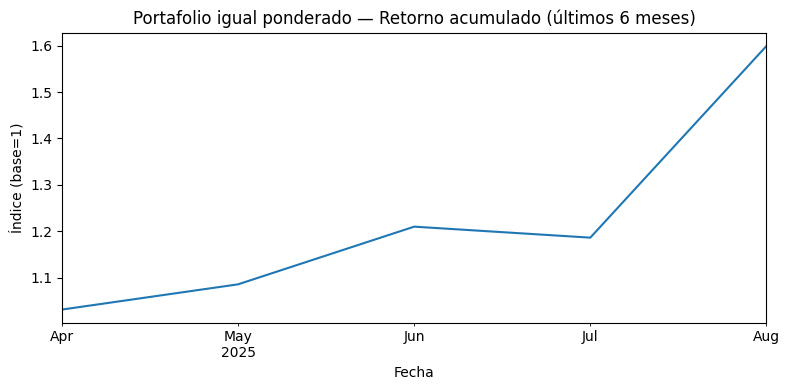

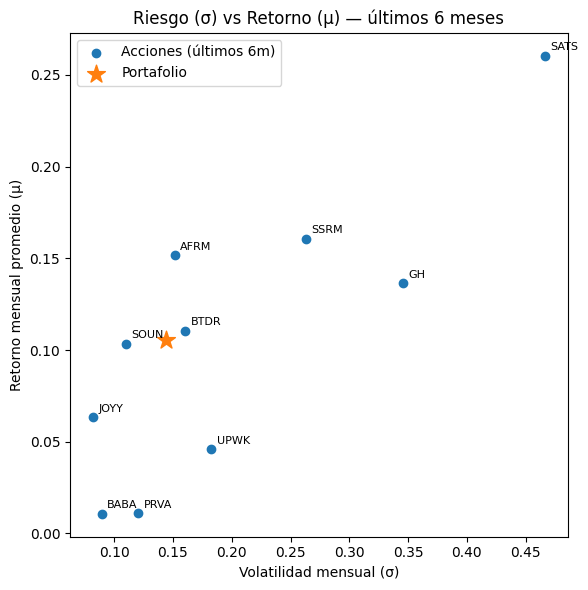

✅ Gráficos guardados en:
 - plots/portfolio_cumulative_last6.png
 - plots/risk_return_scatter_last6.png


In [ ]:
# Objetivo: calcular métricas simples del portafolio y graficar:
# (A) retorno acumulado del portafolio en los últimos 6 meses
# (B) dispersión riesgo (σ) vs retorno (μ) para comparar acciones vs portafolio

import matplotlib.pyplot as plt

# 1) Métricas del portafolio (mensuales)
pm = portfolio_returns_last6["Portfolio"].mean()  # μ: retorno promedio mensual
pv = portfolio_returns_last6["Portfolio"].std()   # σ: volatilidad mensual
print(f"Retorno promedio mensual del portafolio (μ): {pm:.4f}")
print(f"Volatilidad mensual del portafolio (σ):     {pv:.4f}")

# 2) Retorno acumulado del portafolio (últimos 6m)
cum_port = (1 + portfolio_returns_last6["Portfolio"]).cumprod()

plt.figure(figsize=(8,4))
cum_port.plot()
plt.title("Portafolio igual ponderado — Retorno acumulado (últimos 6 meses)")
plt.xlabel("Fecha")
plt.ylabel("Índice (base=1)")
plt.tight_layout()
plt.savefig("plots/portfolio_cumulative_last6.png")
plt.show()

# 3) Riesgo–retorno por acción vs portafolio
means = stock_returns_last6.mean()   # μ por acción
vols  = stock_returns_last6.std()    # σ por acción

plt.figure(figsize=(6,6))
plt.scatter(vols, means, label="Acciones (últimos 6m)")
plt.scatter([pv], [pm], marker="*", s=180, label="Portafolio", zorder=3)

# Etiquetas para identificar los tickers en el scatter
for s in means.index:
    if s in vols.index:
        plt.annotate(s, (vols[s], means[s]), fontsize=8, xytext=(4,4), textcoords="offset points")

plt.title("Riesgo (σ) vs Retorno (μ) — últimos 6 meses")
plt.xlabel("Volatilidad mensual (σ)")
plt.ylabel("Retorno mensual promedio (μ)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/risk_return_scatter_last6.png")
plt.show()

print("✅ Gráficos guardados en:")
print(" - plots/portfolio_cumulative_last6.png")
print(" - plots/risk_return_scatter_last6.png")


# 📊 Ejercicio 1 — Conclusiones Finales

En este ejercicio se implementó un flujo completo que integra **web scraping**, **descarga de datos financieros** y **análisis de portafolio**:

1. **Scraping con Selenium**  
   - Se extrajeron los **Top 50 Gainers** desde Yahoo Finance.  
   - Los símbolos y nombres se almacenaron en un archivo CSV para facilitar su uso posterior.  

2. **Descarga de históricos con `yfinance`**  
   - Para cada símbolo, se recuperaron los precios ajustados de cierre mensual en un horizonte de **1 año** (`period="1y"`, `interval="1mo"`).  
   - Se construyó un DataFrame consolidado con todos los precios.  

3. **Construcción de portafolio**  
   - Se seleccionaron las 10 acciones con mejor desempeño en los **primeros 6 meses**.  
   - Se armó un portafolio **igual ponderado (10%)** con esas 10 acciones.  

4. **Evaluación de desempeño (últimos 6 meses)**  
   - Se calcularon retornos mensuales individuales y del portafolio.  
   - Se graficó el **retorno acumulado** y la relación **riesgo (volatilidad) vs retorno**.

---

## 📈 Principales resultados

- **Retorno acumulado:**  
  El portafolio mostró un crecimiento significativo, alcanzando un índice cercano a **1.6** en los últimos 6 meses (≈ **+60%**).  

- **Estabilidad y diversificación:**  
  Aunque hubo una fase de meseta a mediados del período, en los últimos meses el portafolio despegó con fuerza.  
  La diversificación permitió mitigar riesgos de acciones individuales sin sacrificar retornos atractivos.  

- **Riesgo vs Retorno:**  
  - El portafolio se ubicó en una **posición intermedia**, con un rendimiento superior al promedio de las acciones individuales y con un riesgo moderado.  
  - Algunas acciones como **SATS y SSRM** ofrecieron retornos extraordinarios, pero con una volatilidad mucho más alta.  
  - Esto confirma que un portafolio diversificado puede lograr una **mejor relación riesgo/retorno** que invertir en un único activo.  

